In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

sns.set_style('whitegrid')
sns.set_context('paper')
sns.despine(offset=10, trim=True)

fp = 'data/preprocessed_filled.csv'
df = pd.read_csv(fp)
df.set_index('date', inplace=True)
df.index = pd.to_datetime(df.index)
info_df = pd.read_csv('data/series.csv')
series = df['value'].dropna()
result = seasonal_decompose(series, model='additive')

<Figure size 432x288 with 0 Axes>

Text(0, 0.5, 'Closing Price')

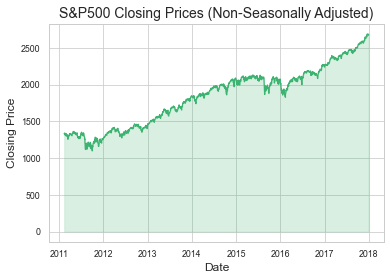

In [10]:
sns.lineplot(data=result.observed, color='mediumseagreen')
plt.fill_between(result.observed.index.values, result.observed, alpha=0.2, color='mediumseagreen')

plt.title('S&P500 Closing Prices (Non-Seasonally Adjusted)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Closing Price', fontsize=12)

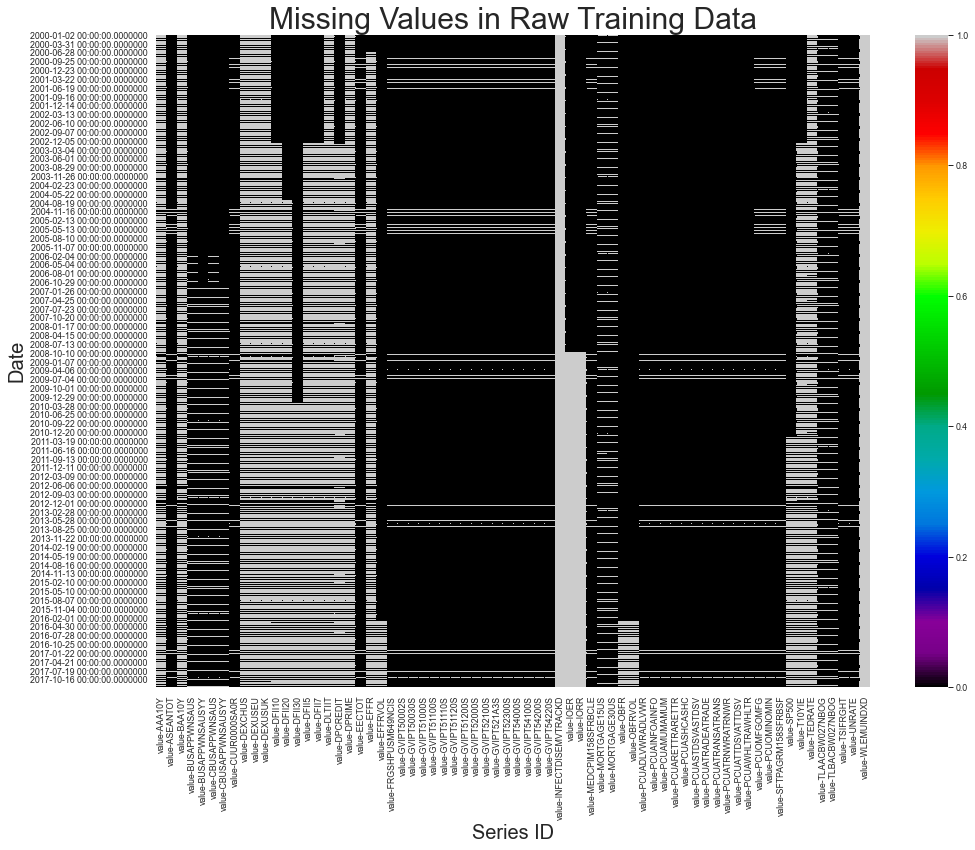

In [11]:
raw_data = pd.read_csv('data/observations_train.csv')
raw_data_pivot = raw_data.pivot_table(index='date', columns='series_id')
_, ax = plt.subplots(1, figsize=(16,12))
sns.heatmap(raw_data_pivot.notnull(), ax=ax, cmap='nipy_spectral')
plt.title('Missing Values in Raw Training Data', fontsize=30)
plt.xlabel('Series ID', fontsize=20)
plt.ylabel('Date', fontsize=20)
plt.savefig('missingness_hm.png', bbox_inches='tight', transparent=True)

In [12]:
# raw_data_pivot.isnull().sum()[raw_data_pivot.isnull().sum() == 0]
raw_data_pivot.index = pd.to_datetime(raw_data_pivot.index)

Text(0.5, 0.98, 'Time Series Examples')

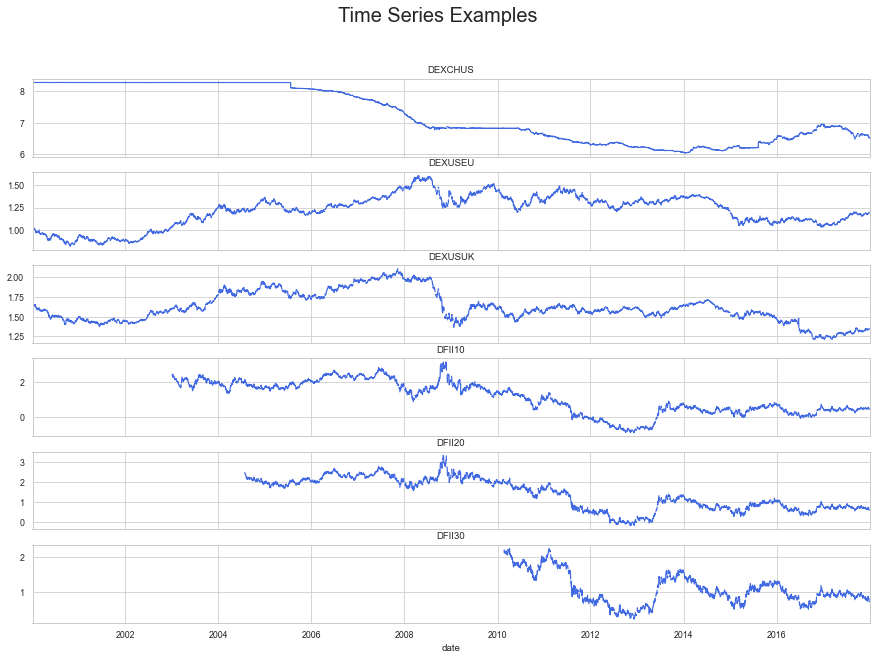

In [13]:
fig,ax = plt.subplots(6,1,figsize=(15,10), sharex=True)
for i, column in enumerate([col for col in raw_data_pivot.columns[8:14]]):
    raw_data_pivot[column].plot(ax=ax[i], color='royalblue')
    ax[i].set_title(column[1])
plt.suptitle('Time Series Examples', fontsize=20)

Text(0.5, 1.0, 'Seasonal Adjustment in Dataset')

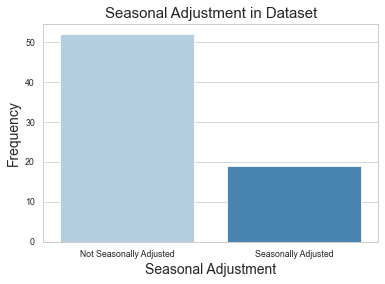

In [14]:
sns.countplot(info_df['seasonal_adjustment'], palette='Blues')
plt.xlabel('Seasonal Adjustment', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Seasonal Adjustment in Dataset', fontsize=15)

In [15]:
from pandas.plotting import autocorrelation_plot
plt.rcParams.update({'figure.figsize':(3,2), 'figure.dpi':120})

non_adjusted = info_df[info_df['seasonal_adjustment'].str.contains('Not')]['series_id']

def plot_seasonality(series_id):
    srs = raw_data_pivot['value', series_id]
    if 'monthly' in info_df[
        info_df['series_id'] == series_id
    ]['frequency'].iloc[0].lower() or 'weekly' in info_df[
        info_df['series_id'] == series_id
    ]['frequency'].iloc[0].lower():
        srs = srs.dropna()
    elif 'daily' in info_df[info_df['series_id'] == series_id]['frequency'].iloc[0].lower():
        resample = srs.resample('M')
        srs = resample.mean().dropna()
    decomposition = seasonal_decompose(srs, model='additive', freq=1).seasonal
    autocorrelation_plot(srs, color='royalblue')
    plt.title(f'Autocorrelation: {series_id}',fontsize=12)
    plt.show()

# plot_seasonality('PCUAINFOAINFO')
# plot_seasonality('AAA10Y')
# for series_id in non_adjusted:
#     try:
#         plot_seasonality(series_id)
#     except KeyError:
#         continue

In [16]:
seasonal_features = ['BUSAPPWNSAUS', 'CBUSAPPWNSAUS', 'FRGSHPUSM649NCIS', 'INFECTDISEMVTRACKD', 'T10YIE', 'WLEMUINDXD']

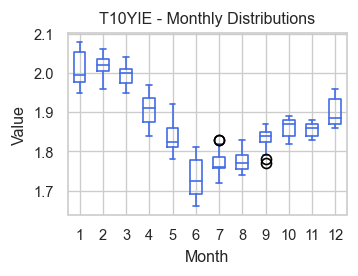

In [17]:
import numpy as np

tmp = raw_data_pivot['value', 'T10YIE']
groups = tmp.groupby(pd.Grouper(freq='MS'))
months = pd.DataFrame()
for name, group in groups:
    vals = list(group.values)
    for _ in range(31 - len(vals)):
        vals.append(np.nan)
    months[name.month] = vals
months.boxplot(color='#446CE4')
plt.xlabel('Month')
plt.ylabel('Value')
plt.title('T10YIE - Monthly Distributions')
plt.show()

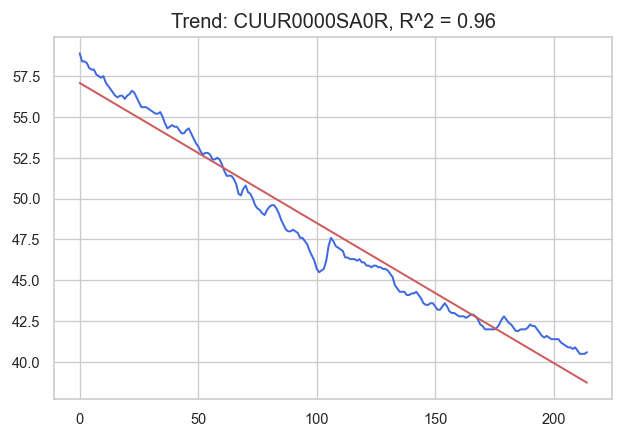

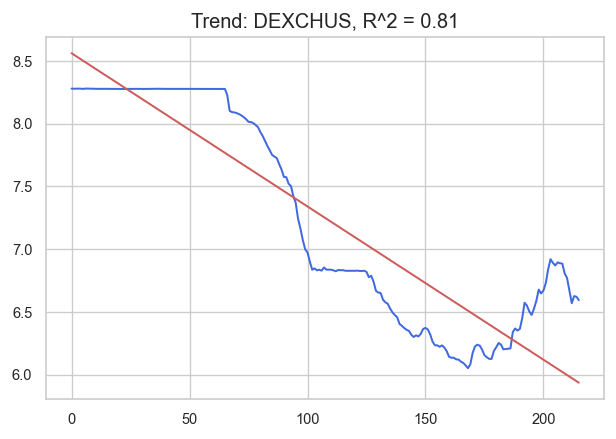

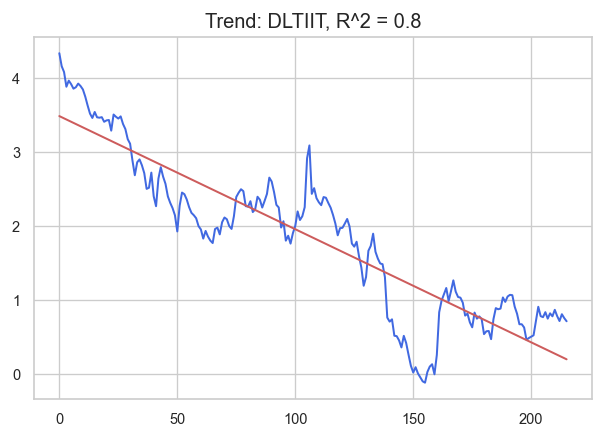

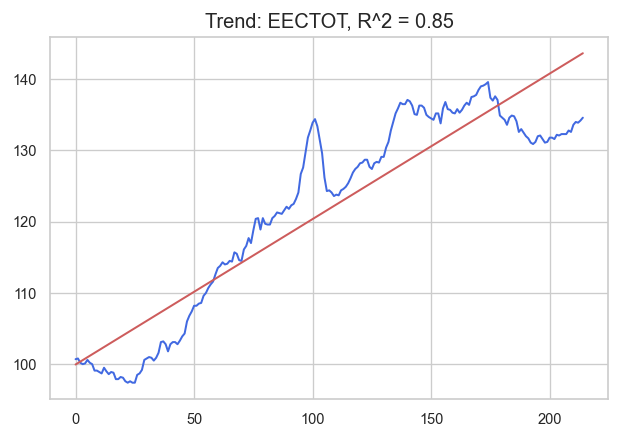

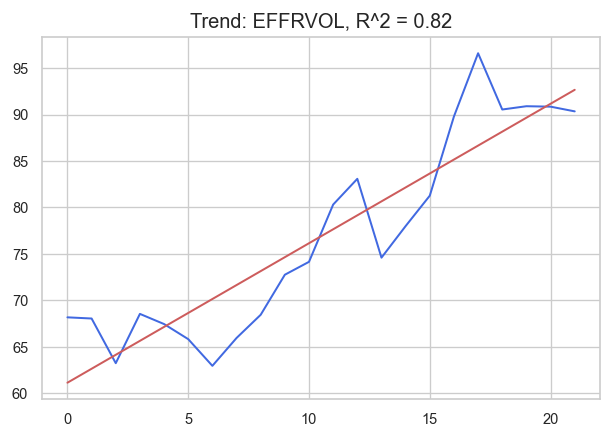

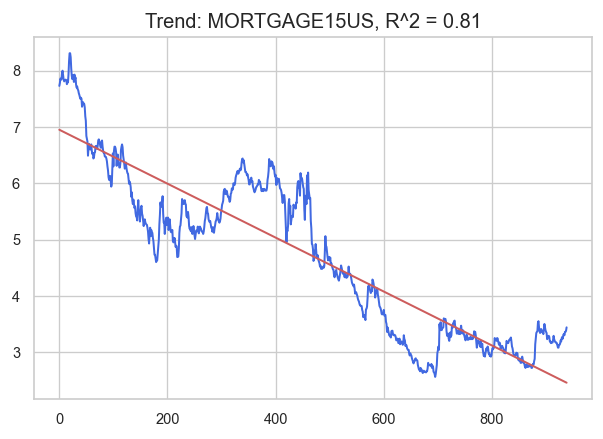

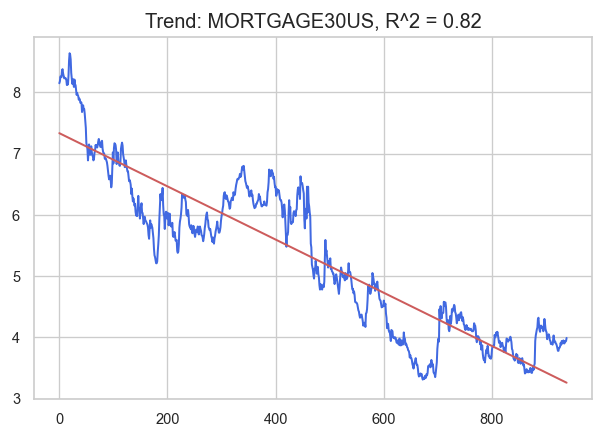

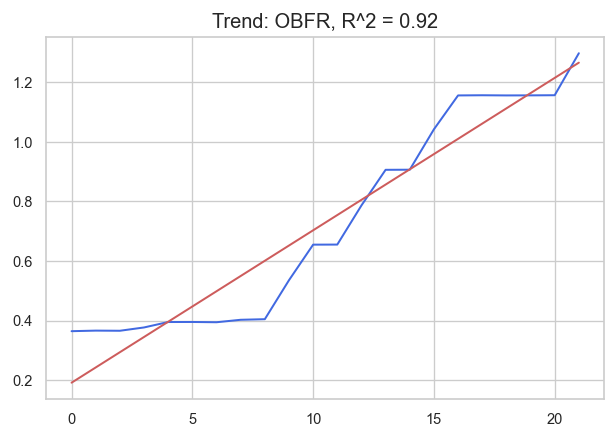

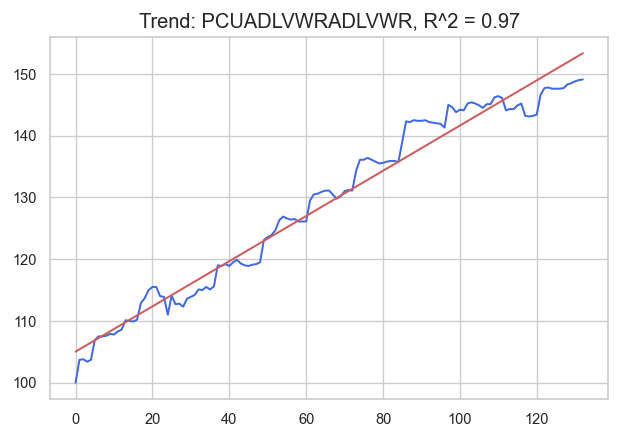

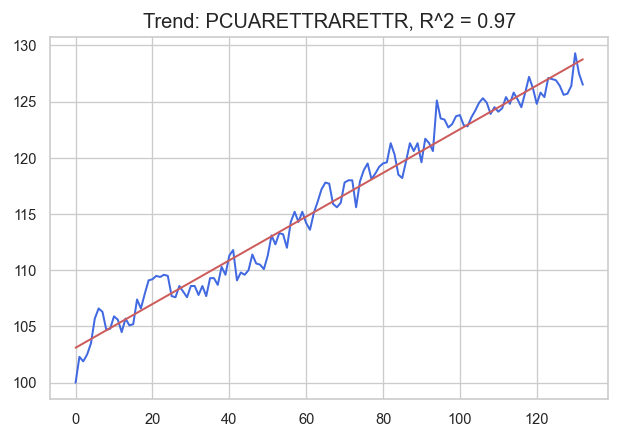

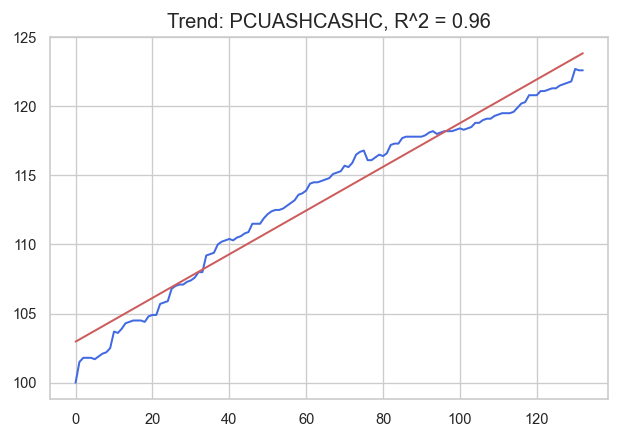

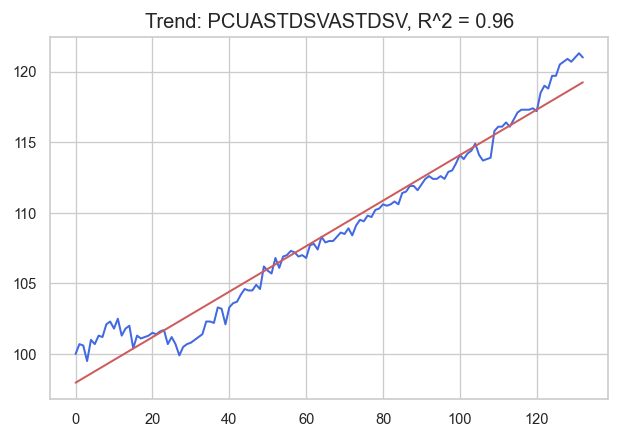

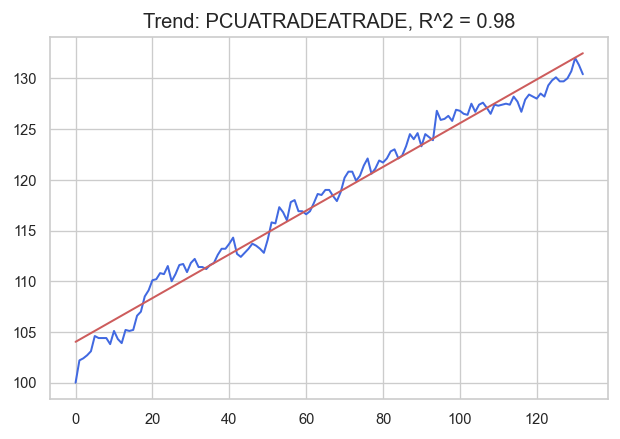

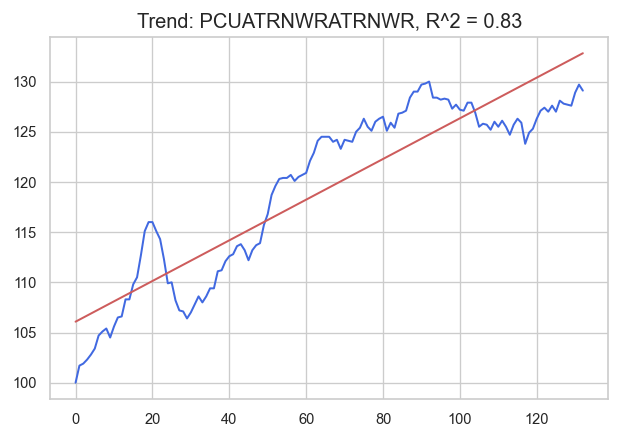

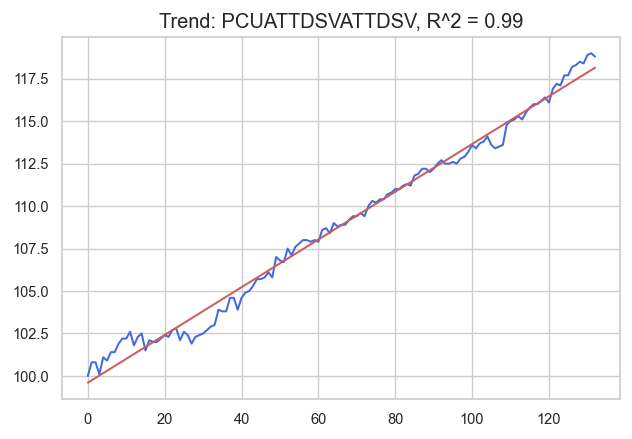

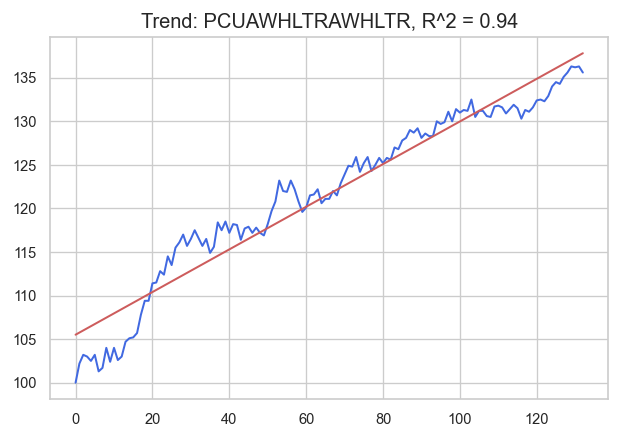

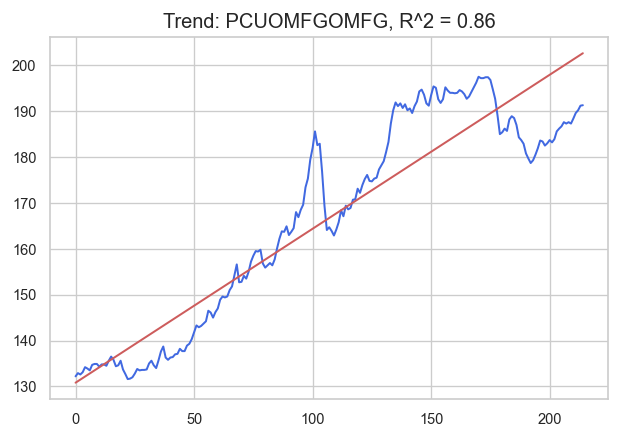

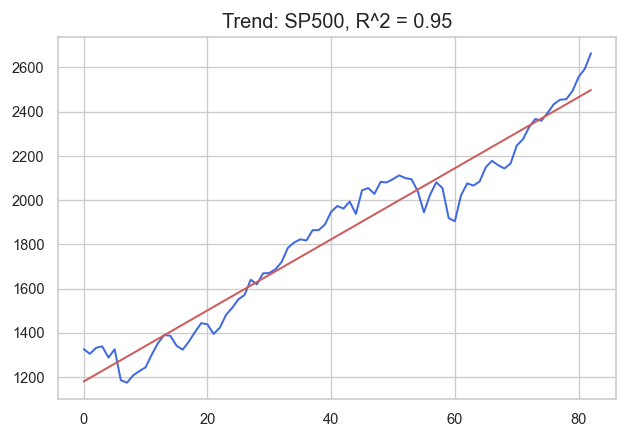

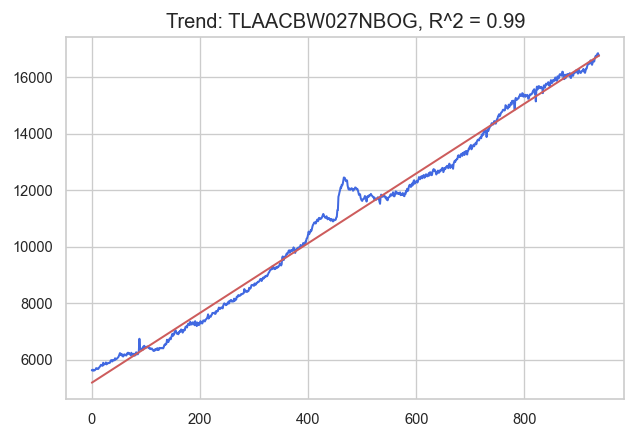

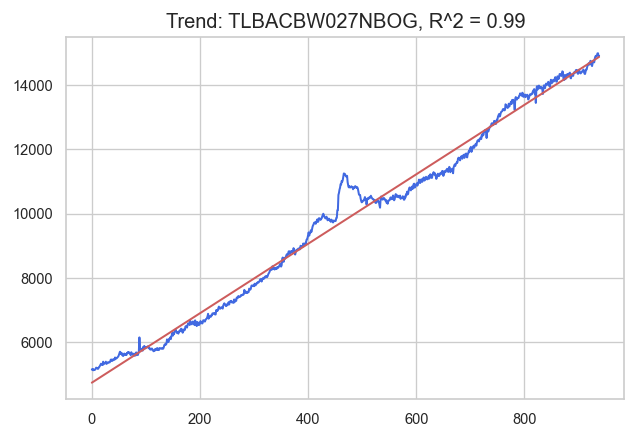

In [41]:
from sklearn.linear_model import LinearRegression
plt.rcParams.update({'figure.figsize':(6,4), 'figure.dpi':120})

trend_features = []

def plot_trend(series_id):
    srs = raw_data_pivot['value', series_id]
    if 'monthly' in info_df[
        info_df['series_id'] == series_id
    ]['frequency'].iloc[0].lower() or 'weekly' in info_df[
        info_df['series_id'] == series_id
    ]['frequency'].iloc[0].lower():
        srs = srs.dropna()
    elif 'daily' in info_df[info_df['series_id'] == series_id]['frequency'].iloc[0].lower():
        resample = srs.resample('M')
        srs = resample.mean().dropna()
    X = [i for i in range(len(srs))]
    X = np.reshape(X, (len(X), 1))
    y = srs.values
    model = LinearRegression()
    model.fit(X, y)
    trend = model.predict(X)
    decomposition = seasonal_decompose(srs, model='additive', period=1).trend
    if model.score(X, y) >= 0.75:
        trend_features.append(series_id)
        plt.plot([i for i in range(len(srs))], decomposition, color='royalblue')
        plt.plot([i for i in range(len(srs))], trend, color='indianred')
        plt.title(f'Trend: {series_id}, R^2 = {round(model.score(X, y), 2)}',fontsize=12)
        plt.show()
    
for series_id in info_df['series_id']:
    try:
        plot_trend(series_id)
    except KeyError:
        continue

In [42]:
trend_features

['CUUR0000SA0R',
 'DEXCHUS',
 'DLTIIT',
 'EECTOT',
 'EFFRVOL',
 'MORTGAGE15US',
 'MORTGAGE30US',
 'OBFR',
 'PCUADLVWRADLVWR',
 'PCUARETTRARETTR',
 'PCUASHCASHC',
 'PCUASTDSVASTDSV',
 'PCUATRADEATRADE',
 'PCUATRNWRATRNWR',
 'PCUATTDSVATTDSV',
 'PCUAWHLTRAWHLTR',
 'PCUOMFGOMFG',
 'SP500',
 'TLAACBW027NBOG',
 'TLBACBW027NBOG']